CAGR: 10.57%
Annual Volatility: 10.90%
Sharpe Ratio: 1.00
Alpha: 2.67%


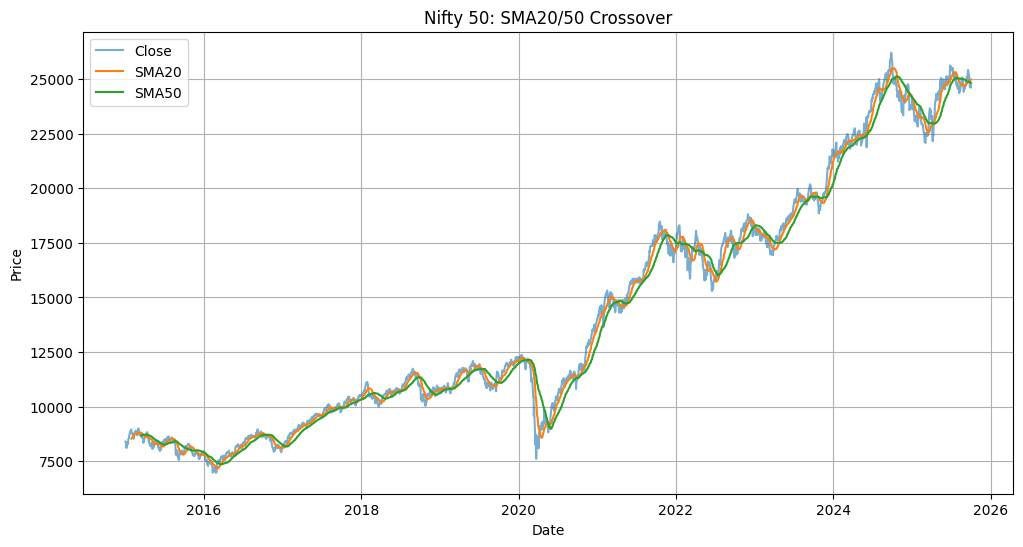

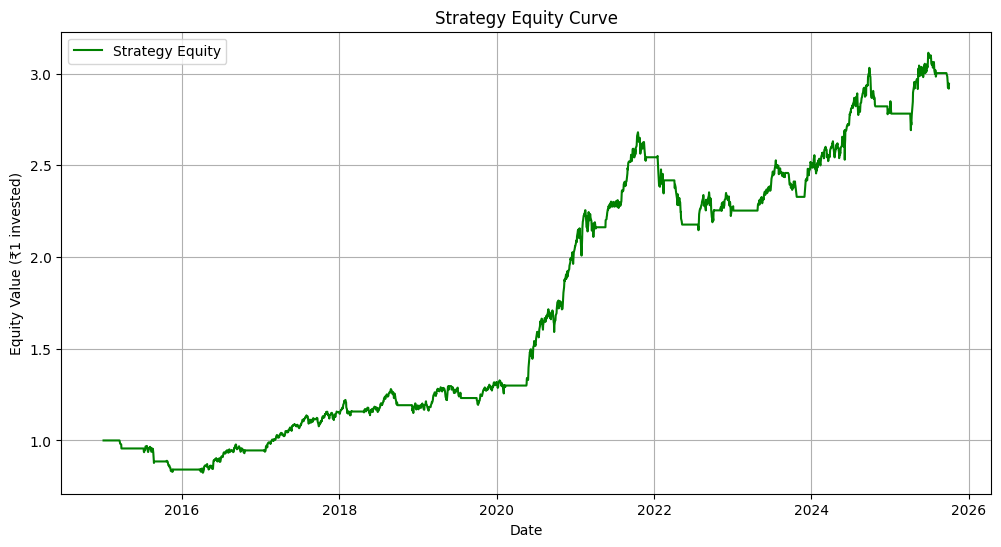

=== SMA Strategy Interpretation ===

CAGR: 10.57% → Good, profitable strategy.
Annual Volatility: 10.90% → Moderate risk.
Sharpe Ratio: 1.00 → Moderate risk-adjusted return.
Alpha: 2.67% → Strategy's excess return over benchmark.

Maximum Drawdown: -19.93% → Low risk period.

Trend Efficiency: 36.19% → 36.19% of days contributed positively to equity growth.


In [3]:
# pip install yfinance pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# --- 1. Download Nifty 50 daily data ---
df = yf.download("^NSEI", start="2015-01-01", auto_adjust=True, progress=False)
df.reset_index(inplace=True)
df = df[['Date', 'Close']].dropna()

# --- 2. Moving averages & signals ---
df['SMA20'] = df['Close'].rolling(20, min_periods=20).mean()
df['SMA50'] = df['Close'].rolling(50, min_periods=50).mean()
df['Signal'] = np.where(df['SMA20'] > df['SMA50'], 1.0, 0.0)
df['Position'] = df['Signal'].shift(1).fillna(0)

# --- 3. Returns & equity curve ---
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Position'] * df['Market_Return']
df['Equity'] = (1 + df['Strategy_Return'].fillna(0)).cumprod()

# --- 4. Performance metrics ---
years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
ending_value = df['Equity'].iloc[-1]
cagr = ending_value**(1/years) - 1

daily_std = df['Strategy_Return'].std()
annual_vol = daily_std * np.sqrt(252)
sharpe = ((df['Strategy_Return'].mean() * 252) / annual_vol if annual_vol > 0 else 0)

# --- 5. Alpha Calculation ---
df['Benchmark_Return'] = df['Market_Return']
strategy_annual_return = (1 + df['Strategy_Return'].mean())**252 - 1
benchmark_annual_return = (1 + df['Benchmark_Return'].mean())**252 - 1
cov_matrix = np.cov(df['Strategy_Return'].dropna(), df['Benchmark_Return'].dropna())
beta = cov_matrix[0, 1] / cov_matrix[1, 1]
rf = 0.06  # Risk-free rate
alpha = strategy_annual_return - (rf + beta * (benchmark_annual_return - rf))

# --- 6. Print Metrics ---
print(f"CAGR: {cagr:.2%}")
print(f"Annual Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Alpha: {alpha:.2%}")

# --- 7. Plot SMA Crossover ---
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close', alpha=0.6)
plt.plot(df['Date'], df['SMA20'], label='SMA20')
plt.plot(df['Date'], df['SMA50'], label='SMA50')
plt.title("Nifty 50: SMA20/50 Crossover")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# --- 8. Plot Equity Curve ---
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Equity'], color='green', label='Strategy Equity')
plt.title("Strategy Equity Curve")
plt.xlabel("Date")
plt.ylabel("Equity Value (₹1 invested)")
plt.legend()
plt.grid()
plt.show()

# --- 9. Strategy Interpretation Function ---
def interpret_strategy(cagr, annual_vol, sharpe, equity_series, alpha):
    print("=== SMA Strategy Interpretation ===\n")
    
    # CAGR
    if cagr > 0.15:
        print(f"CAGR: {cagr:.2%} → Excellent growth.")
    elif cagr > 0.08:
        print(f"CAGR: {cagr:.2%} → Good, profitable strategy.")
    elif cagr > 0:
        print(f"CAGR: {cagr:.2%} → Modest growth, may need optimization.")
    else:
        print(f"CAGR: {cagr:.2%} → Strategy lost money.")
    
    # Volatility
    if annual_vol < 0.1:
        print(f"Annual Volatility: {annual_vol:.2%} → Low risk, stable performance.")
    elif annual_vol < 0.2:
        print(f"Annual Volatility: {annual_vol:.2%} → Moderate risk.")
    else:
        print(f"Annual Volatility: {annual_vol:.2%} → High risk, returns fluctuate a lot.")
    
    # Sharpe
    if sharpe > 1.5:
        print(f"Sharpe Ratio: {sharpe:.2f} → Excellent risk-adjusted return.")
    elif sharpe > 1.0:
        print(f"Sharpe Ratio: {sharpe:.2f} → Good risk-adjusted performance.")
    elif sharpe > 0.5:
        print(f"Sharpe Ratio: {sharpe:.2f} → Moderate risk-adjusted return.")
    else:
        print(f"Sharpe Ratio: {sharpe:.2f} → Weak risk-adjusted performance.")
    
    # Alpha
    print(f"Alpha: {alpha:.2%} → Strategy's excess return over benchmark.\n")
    
    # Drawdowns
    rolling_max = equity_series.cummax()
    drawdown = (equity_series - rolling_max) / rolling_max
    max_dd = drawdown.min()
    print(f"Maximum Drawdown: {max_dd:.2%} → {'Low' if max_dd > -0.2 else 'Moderate' if max_dd > -0.4 else 'High'} risk period.\n")
    
    # Trend efficiency
    net_up_days = (equity_series.diff() > 0).sum()
    total_days = len(equity_series)
    trend_efficiency = net_up_days / total_days
    print(f"Trend Efficiency: {trend_efficiency:.2%} → {trend_efficiency:.2%} of days contributed positively to equity growth.")

# --- 10. Call Interpretation ---
interpret_strategy(cagr, annual_vol, sharpe, df['Equity'], alpha)